In [1]:
!pip install fastaudio
!pip install fastai==2.5.2
!pip install matplotlib==3.2.2
!pip install scikit-learn==1.0.2

  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 194 kB 6.0 MB/s            
     |████████████████████████████████| 1.9 MB 38.2 MB/s            
     |████████████████████████████████| 53 kB 1.9 MB/s             
     |████████████████████████████████| 183 kB 39.6 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 804.1 MB 2.2 kB/s             
  Created wheel for librosa: filename=librosa-0.8.0-py3-none-any.whl size=201395 sha256=5674921162320b7469f66a96538bc5813e420df9981e5658ca4ef26748b72250
  Stored in directory: /root/.cache/pip/wheels/de/1e/aa/d91797ae7e1ce11853ee100bee9d1781ae9d750e7458c95afb
  Created wheel for colorednoise: filename=colorednoise-1.1.1-py3-none-any.whl size=3982 sha256=790be24577a2c924d8553b58fbc050ad36566fe39c23477033096e3a7d41ea6d
  Stored in directory: /root/.cache/pip/wheels/1a/ca/93/dfd64286aef6fc206b727bd4cf2d5c17efe34d62b918c8f4a7
Successfully built librosa colorednoise
  Att

In [1]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import*
from imblearn.metrics import specificity_score
from keras.utils.np_utils import to_categorical   

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:47: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  '"torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. '


# Data preprocessing 

## Load data

In [2]:
# select data path
path = '../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/'

In [3]:
# load the given csv file
org_df = pd.read_csv(path+"patient_diagnosis.csv", names=['pid', 'label'])
org_df.head()

pid    label
0  101     URTI
1  102  Healthy
2  103   Asthma
3  104     COPD
4  105     URTI

In [4]:
# load all audio file paths in a list
all_files = get_files(path, extensions='.wav', recurse=True)
all_files[:3]

(#3) [Path('../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/162_1b2_Ar_mc_AKGC417L.wav'),Path('../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/193_1b2_Pl_mc_AKGC417L.wav'),Path('../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/138_2p2_Ll_mc_AKGC417L.wav')]

## Create dataframe for dataloader

3 class classification task:
- Healthy = 35 
- Chronic Diseases (COPD, Bronchiectasis and Asthma) 793+16+1 = 810
- and Non-Chronic Diseases (URTI, LRTI, Pneumonia and Bronchiolitis) = 23+2+37+13=75

In [5]:
# save all audios filename and it's corresponding labels in lists
file_names = []
labels = []
for i in all_files:
    name = str(i).split('/')[-1]
    file_names.append(name)
    id = name.split('_')[0]
    label = org_df[org_df['pid']==int(id)]['label'].values[0]
    if (label == 'COPD' or label == 'Bronchiectasis' or label == 'Asthma'):
        labels.append('Chronic Disease')
    elif (label == 'URTI' or label == 'LRTI' or label =='Pneumonia' or label =='Bronchiolitis'):
        labels.append('Non-Chronic Disease')
    else:
        labels.append(label)
        
print("total files:", len(file_names))
print("total labels:", len(labels))

print(file_names[:3])
print(labels[:3])

Counter(labels)

total files: 920
total labels: 920
['162_1b2_Ar_mc_AKGC417L.wav', '193_1b2_Pl_mc_AKGC417L.wav', '138_2p2_Ll_mc_AKGC417L.wav']
['Chronic Disease', 'Chronic Disease', 'Chronic Disease']


Counter({'Chronic Disease': 810, 'Non-Chronic Disease': 75, 'Healthy': 35})

In [6]:
# create a dataframe using the file_names and labels list
df = pd.DataFrame({'filename' : file_names, 'category': labels})
six_df = df.copy()
six_df

filename         category
0    162_1b2_Ar_mc_AKGC417L.wav  Chronic Disease
1    193_1b2_Pl_mc_AKGC417L.wav  Chronic Disease
2    138_2p2_Ll_mc_AKGC417L.wav  Chronic Disease
3    207_2b2_Ar_mc_AKGC417L.wav  Chronic Disease
4    176_2b3_Pr_mc_AKGC417L.wav  Chronic Disease
..                          ...              ...
915  162_2b4_Al_mc_AKGC417L.wav  Chronic Disease
916  186_2b3_Ar_mc_AKGC417L.wav  Chronic Disease
917  111_1b3_Tc_sc_Meditron.wav  Chronic Disease
918  151_2p3_Al_mc_AKGC417L.wav  Chronic Disease
919  170_1b4_Pl_mc_AKGC417L.wav  Chronic Disease

[920 rows x 2 columns]

Chronic Disease        810
Non-Chronic Disease     75
Healthy                 35
Name: category, dtype: int64

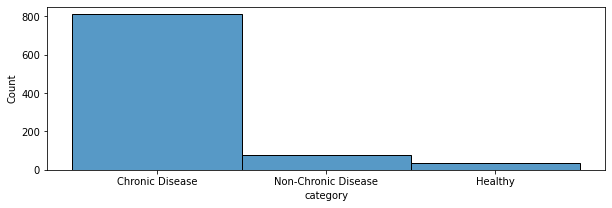

In [7]:
import seaborn as sns

plt.figure(figsize=(10,3))
sns.histplot(six_df['category'])

six_df['category'].value_counts()

In [8]:
six_df.to_csv('six_df.csv', index=False) 

## Mel-Spectrogram and Augmentation

In [27]:
# resize audio to a uniform length and create mel-spectrogram from audio

cfg = AudioConfig.BasicMelSpectrogram(sample_rate=22050, n_fft=1024, hop_length=512, f_min=0.0, f_max=4000,
                                      n_mels=64, normalized=False, norm=None, mel=True, to_db=True)

a2s = AudioToSpec.from_cfg(cfg)
crop21s = ResizeSignal(21000)
SGR = SGRoll(max_shift_pct=0.5, direction=0)
MT = MaskTime(size=5)
MF =  MaskFreq(size=5)

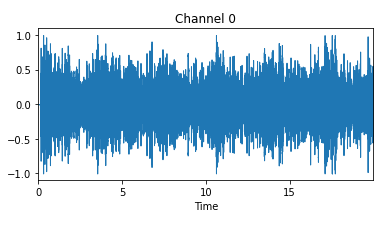

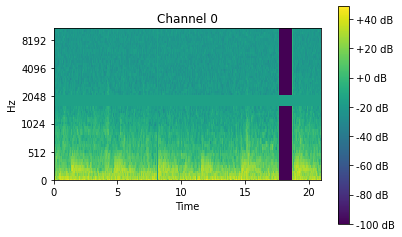

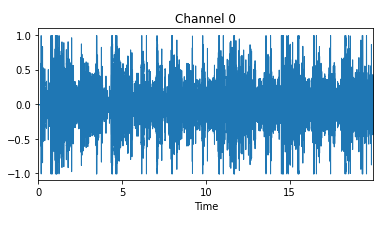

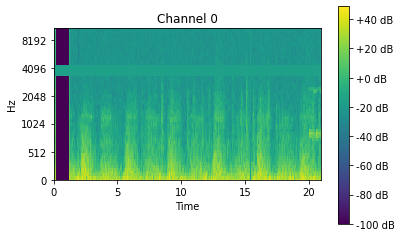

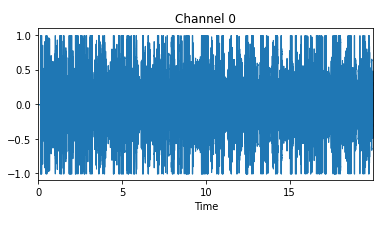

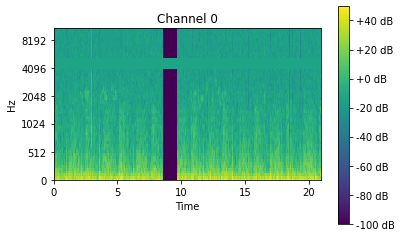

In [28]:
# check transformations
pipe = Pipeline([AudioTensor.create, crop21s, a2s, SGR, MT, MF])

for fn in all_files[66:69]:
      audio = AudioTensor.create(fn)
      audio.show()
      pipe(fn).show()

## Dataloader

In [29]:
six_df, six_df_test = train_test_split(six_df, test_size=0.20, random_state=42, 
                                       stratify=six_df.category.values)

print(six_df.category.value_counts())
print(six_df_test.category.value_counts())

Chronic Disease        518
Non-Chronic Disease     48
Healthy                 22
Name: category, dtype: int64
Chronic Disease        130
Non-Chronic Disease     12
Healthy                  6
Name: category, dtype: int64


Setting-up type transforms pipelines
13   193_1b4_Lr_mc_AKGC417L.wav  Chronic Disease
515  107_2b5_Ar_mc_AKGC417L.wav  Chronic Disease
885  178_2b2_Ar_mc_AKGC417L.wav  Chronic Disease
247  213_1p2_Al_mc_AKGC417L.wav  Chronic Disease
94   203_2p3_Ar_mc_AKGC417L.wav  Chronic Disease
..                          ...              ...
140  176_1b4_Ar_mc_AKGC417L.wav  Chronic Disease
547  134_2b1_Al_mc_LittC2SE.wav  Chronic Disease
169  203_1p2_Ar_mc_AKGC417L.wav  Chronic Disease
125  178_2b2_Lr_mc_AKGC417L.wav  Chronic Disease
157  116_1b2_Tc_sc_Meditron.wav  Chronic Disease

[588 rows x 2 columns]
Found 588 items
2 datasets of sizes 470,118
Setting up Pipeline: ColReader -- {'cols': 'filename', 'pref': '../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/', 'suff': '', 'label_delim': None} -> partial
Setting up Pipeline: ColReader -- {'cols': 'category', 'pref': '', 'suff': '', 'label_delim': None} -> Categorize -- {'vocab': None, 's

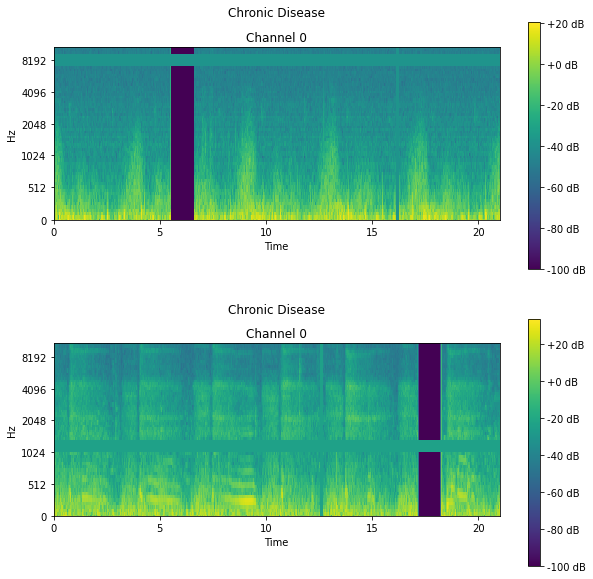

In [30]:
item_tfms = [crop21s, a2s, SGR, MT, MF]

auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = ColReader("filename", pref= path+"audio_and_txt_files/"),
                 splitter = TrainTestSplitter(test_size=0.2, random_state=42, 
                                              stratify=six_df.category.values),
                 item_tfms = item_tfms,
                 get_y = ColReader("category"))


auds.summary(six_df, show_batch=True, figsize=(10, 10))

## Weighted dataloaders

In [31]:
dsets = auds.datasets(six_df)

In [32]:
count = Counter(labels)
wgts = [1/count[dsets.vocab[label]] for cat, label in dsets.train]
wgts[:10]
np.unique(np.array(wgts), return_counts=True)

(array([0.00123457, 0.01333333, 0.02857143]), array([414,  38,  18]))

In [33]:
dls = auds.dataloaders(six_df, bs=64, dl_type=WeightedDL, wgts=wgts)

In [34]:
for i in range(10):
    x,y = dls.one_batch()
    print(np.unique(y.cpu(), return_counts=True))

(array([0, 1, 2]), array([23, 23, 18]))
(array([0, 1, 2]), array([21, 20, 23]))
(array([0, 1, 2]), array([15, 30, 19]))
(array([0, 1, 2]), array([24, 18, 22]))
(array([0, 1, 2]), array([21, 22, 21]))
(array([0, 1, 2]), array([25, 22, 17]))
(array([0, 1, 2]), array([18, 24, 22]))
(array([0, 1, 2]), array([16, 17, 31]))
(array([0, 1, 2]), array([20, 22, 22]))
(array([0, 1, 2]), array([22, 20, 22]))


In [35]:
test_dl = dls.test_dl(six_df_test, with_labels=True)

In [36]:
print(dls.train.items.category.value_counts())
print(dls.valid.items.category.value_counts())
print(test_dl.items.category.value_counts())

Chronic Disease        414
Non-Chronic Disease     38
Healthy                 18
Name: category, dtype: int64
Chronic Disease        104
Non-Chronic Disease     10
Healthy                  4
Name: category, dtype: int64
Chronic Disease        130
Non-Chronic Disease     12
Healthy                  6
Name: category, dtype: int64


# Models: Fine-tuning

### ResNet-18

Better model found at epoch 0 with accuracy value: 0.32203391194343567.


Better model found at epoch 0 with accuracy value: 0.4576271176338196.
Better model found at epoch 1 with accuracy value: 0.6271186470985413.
Better model found at epoch 2 with accuracy value: 0.7542372941970825.
Better model found at epoch 3 with accuracy value: 0.7627118825912476.
Better model found at epoch 4 with accuracy value: 0.8474576473236084.
Better model found at epoch 8 with accuracy value: 0.8728813529014587.
Better model found at epoch 12 with accuracy value: 0.8813559412956238.
Better model found at epoch 13 with accuracy value: 0.8983050584793091.
Better model found at epoch 18 with accuracy value: 0.9067796468734741.
Better model found at epoch 20 with accuracy value: 0.9152542352676392.
Better model found at epoch 22 with accuracy value: 0.9322034120559692.
Better model found at epoch 24 with accuracy value: 0.9491525292396545.
Better model found at epoch 26 with accuracy value: 0.9576271176338196.
No improvement since epoch 26: early stopping


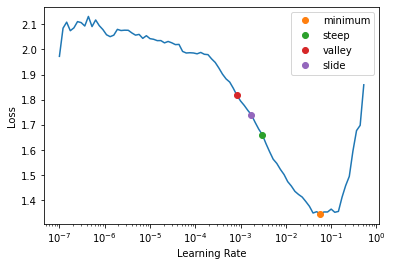

In [37]:
learn = cnn_learner(dls, resnet18, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

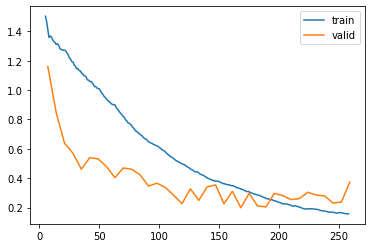

In [38]:
learn.recorder.plot_loss()

0.9121621621621622 0.8503531748560746 0.6738643665180396 0.7320512820512821 0.9686550676608672 0.6348039215686274
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       130
           1       0.38      0.50      0.43         6
           2       0.53      0.75      0.62        12

    accuracy                           0.91       148
   macro avg       0.63      0.73      0.67       148
weighted avg       0.94      0.91      0.92       148



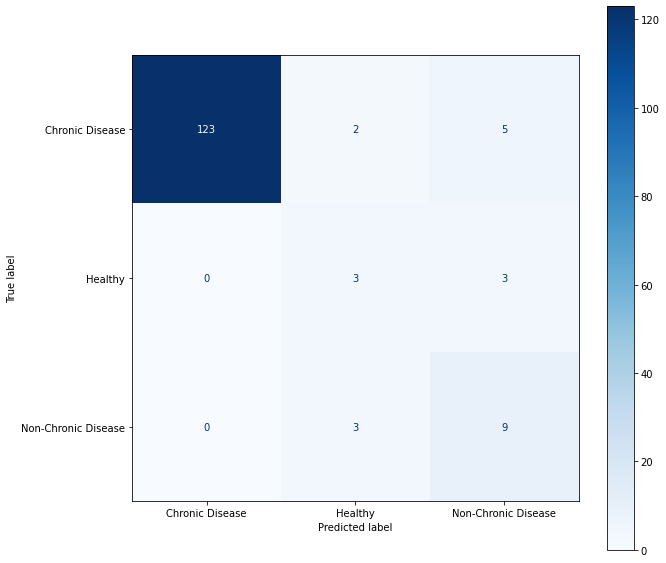

In [39]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### ResNet-34

Better model found at epoch 0 with accuracy value: 0.11864406615495682.


Better model found at epoch 0 with accuracy value: 0.4576271176338196.
Better model found at epoch 1 with accuracy value: 0.7118644118309021.
Better model found at epoch 2 with accuracy value: 0.7542372941970825.
Better model found at epoch 3 with accuracy value: 0.7796609997749329.
Better model found at epoch 4 with accuracy value: 0.8220338821411133.
Better model found at epoch 5 with accuracy value: 0.8644067645072937.
Better model found at epoch 7 with accuracy value: 0.8813559412956238.
Better model found at epoch 8 with accuracy value: 0.8983050584793091.
Better model found at epoch 10 with accuracy value: 0.9067796468734741.
Better model found at epoch 11 with accuracy value: 0.9237288236618042.
Better model found at epoch 14 with accuracy value: 0.9406779408454895.
No improvement since epoch 14: early stopping


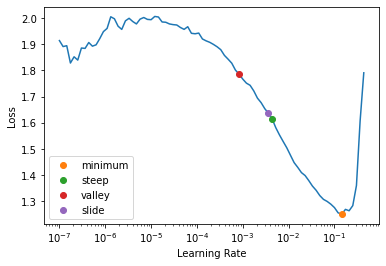

In [40]:
learn = cnn_learner(dls, resnet34, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

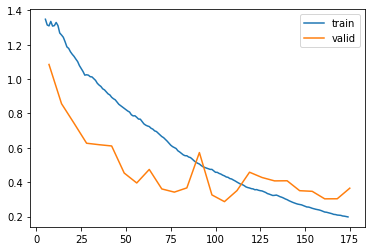

In [41]:
learn.recorder.plot_loss()

0.8918918918918919 0.8806510632421983 0.687218045112782 0.7999999999999999 0.9613021264843966 0.6322463768115942
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       130
           1       0.38      0.50      0.43         6
           2       0.52      1.00      0.69        12

    accuracy                           0.89       148
   macro avg       0.63      0.80      0.69       148
weighted avg       0.94      0.89      0.91       148



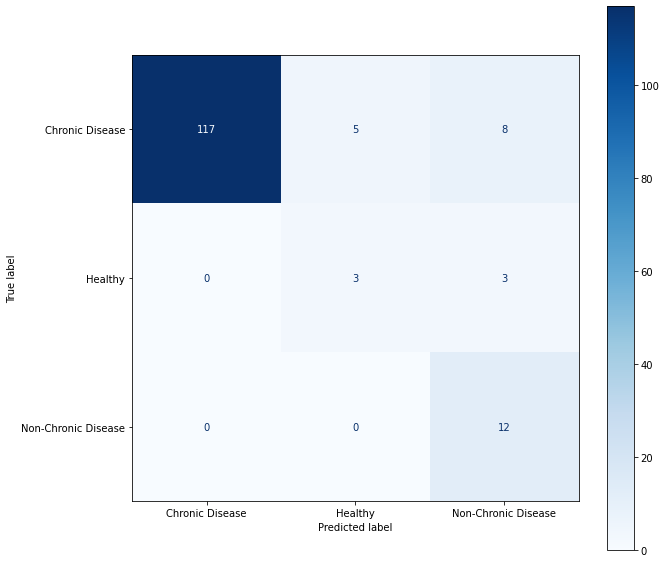

In [42]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### ResNet-50

Better model found at epoch 0 with accuracy value: 0.41525423526763916.


Better model found at epoch 0 with accuracy value: 0.5762711763381958.
Better model found at epoch 1 with accuracy value: 0.6694915294647217.
Better model found at epoch 2 with accuracy value: 0.7881355881690979.
Better model found at epoch 3 with accuracy value: 0.8389830589294434.
Better model found at epoch 5 with accuracy value: 0.8898305296897888.
Better model found at epoch 11 with accuracy value: 0.8983050584793091.
Better model found at epoch 13 with accuracy value: 0.9067796468734741.
Better model found at epoch 15 with accuracy value: 0.9152542352676392.
Better model found at epoch 20 with accuracy value: 0.9322034120559692.
Better model found at epoch 26 with accuracy value: 0.9491525292396545.
No improvement since epoch 26: early stopping


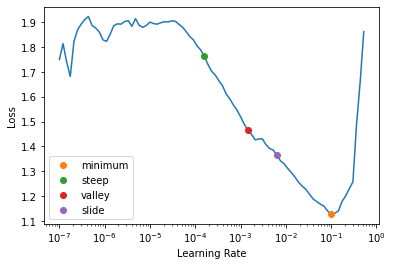

In [43]:
learn = cnn_learner(dls, resnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

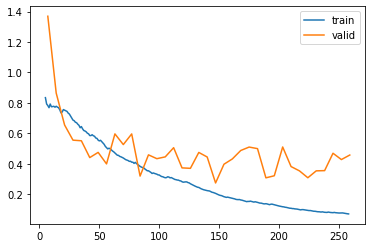

In [44]:
learn.recorder.plot_loss()

0.9121621621621622 0.881266626067786 0.7506613756613757 0.8102564102564104 0.9522768418791617 0.7194899817850637
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       130
           1       0.67      0.67      0.67         6
           2       0.50      0.83      0.62        12

    accuracy                           0.91       148
   macro avg       0.72      0.81      0.75       148
weighted avg       0.94      0.91      0.92       148



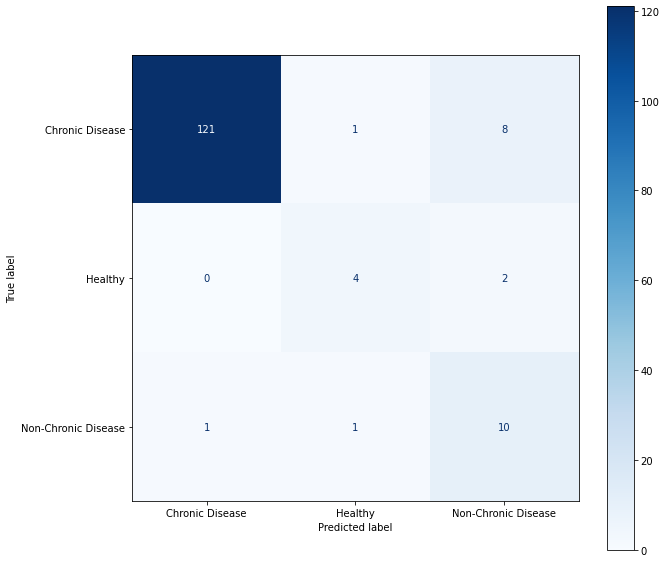

In [45]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### ResNet-101

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.8135592937469482.


Better model found at epoch 0 with accuracy value: 0.5762711763381958.
Better model found at epoch 1 with accuracy value: 0.6864407062530518.
Better model found at epoch 2 with accuracy value: 0.7881355881690979.
Better model found at epoch 3 with accuracy value: 0.8305084705352783.
Better model found at epoch 4 with accuracy value: 0.8389830589294434.
Better model found at epoch 5 with accuracy value: 0.8474576473236084.
Better model found at epoch 6 with accuracy value: 0.8898305296897888.
Better model found at epoch 10 with accuracy value: 0.9067796468734741.
Better model found at epoch 17 with accuracy value: 0.9152542352676392.
Better model found at epoch 22 with accuracy value: 0.9237288236618042.
Better model found at epoch 24 with accuracy value: 0.9322034120559692.
Better model found at epoch 27 with accuracy value: 0.9406779408454895.
Better model found at epoch 30 with accuracy value: 0.9491525292396545.
No improvement since epoch 30: early stopping


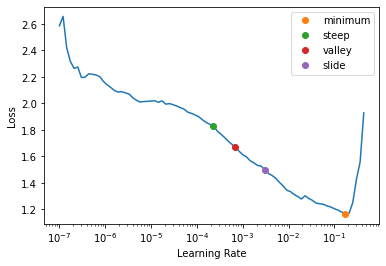

In [46]:
learn = cnn_learner(dls, resnet101, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

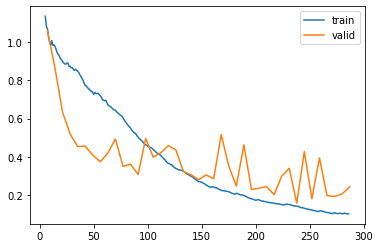

In [47]:
learn.recorder.plot_loss()

0.918918918918919 0.8413144654756088 0.7210722340930674 0.7598290598290598 0.9227998711221579 0.6904761904761904
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       130
           1       0.43      0.50      0.46         6
           2       0.67      0.83      0.74        12

    accuracy                           0.92       148
   macro avg       0.69      0.76      0.72       148
weighted avg       0.93      0.92      0.92       148



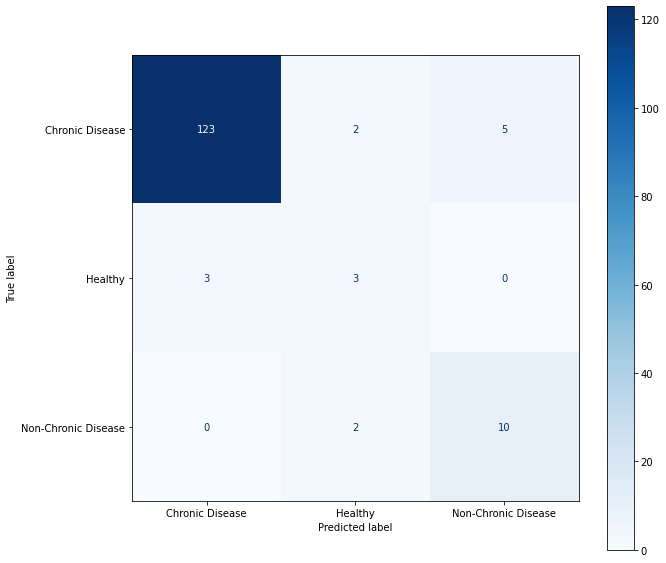

In [48]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### vgg16_bn

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.3813559412956238.


Better model found at epoch 0 with accuracy value: 0.694915235042572.
Better model found at epoch 1 with accuracy value: 0.8135592937469482.
Better model found at epoch 2 with accuracy value: 0.8389830589294434.
Better model found at epoch 4 with accuracy value: 0.8728813529014587.
Better model found at epoch 5 with accuracy value: 0.8983050584793091.
Better model found at epoch 7 with accuracy value: 0.9152542352676392.
Better model found at epoch 10 with accuracy value: 0.9237288236618042.
Better model found at epoch 14 with accuracy value: 0.9322034120559692.
No improvement since epoch 14: early stopping


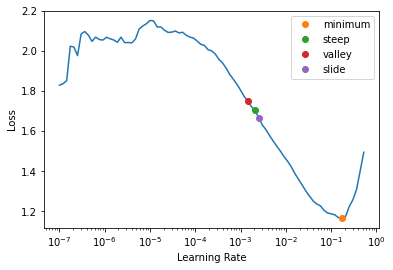

In [49]:
learn = cnn_learner(dls, vgg16_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

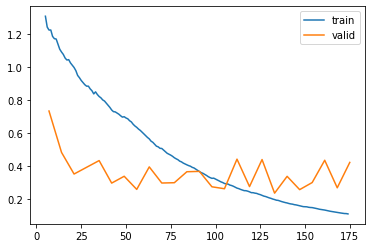

In [50]:
learn.recorder.plot_loss()

0.9054054054054054 0.85906685715095 0.6697835497835497 0.7521367521367521 0.9659969621651477 0.6405797101449275
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       130
           1       0.40      0.33      0.36         6
           2       0.52      1.00      0.69        12

    accuracy                           0.91       148
   macro avg       0.64      0.75      0.67       148
weighted avg       0.94      0.91      0.91       148



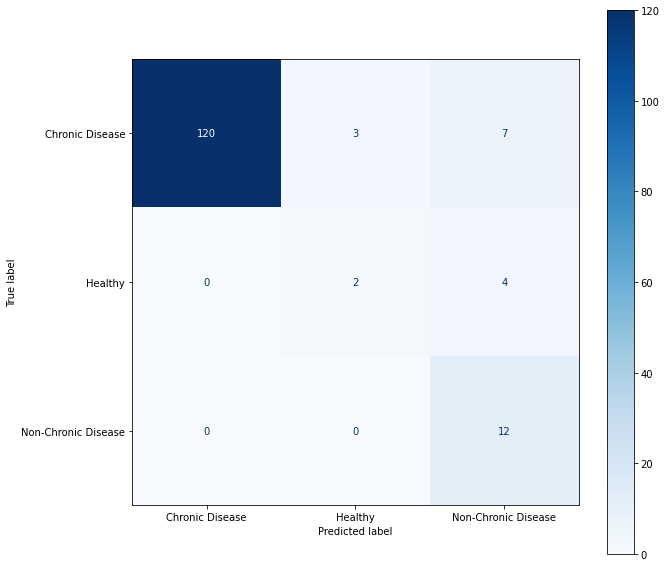

In [51]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### vgg19_bn

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.3813559412956238.


Better model found at epoch 0 with accuracy value: 0.5762711763381958.
Better model found at epoch 1 with accuracy value: 0.7711864113807678.
Better model found at epoch 2 with accuracy value: 0.7966101765632629.
Better model found at epoch 3 with accuracy value: 0.8644067645072937.
Better model found at epoch 5 with accuracy value: 0.8983050584793091.
Better model found at epoch 6 with accuracy value: 0.9067796468734741.
Better model found at epoch 7 with accuracy value: 0.9406779408454895.
Better model found at epoch 13 with accuracy value: 0.9576271176338196.
Better model found at epoch 14 with accuracy value: 0.9661017060279846.
Better model found at epoch 19 with accuracy value: 0.9830508232116699.
No improvement since epoch 19: early stopping


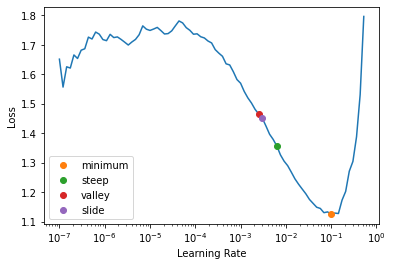

In [52]:
learn = cnn_learner(dls, vgg19_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

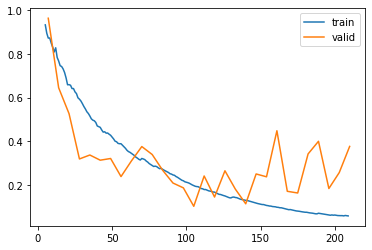

In [53]:
learn.recorder.plot_loss()

0.9256756756756757 0.818504769188282 0.7112707112707112 0.711965811965812 0.9250437264107522 0.7160575858250278
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       130
           1       0.60      0.50      0.55         6
           2       0.57      0.67      0.62        12

    accuracy                           0.93       148
   macro avg       0.72      0.71      0.71       148
weighted avg       0.93      0.93      0.93       148



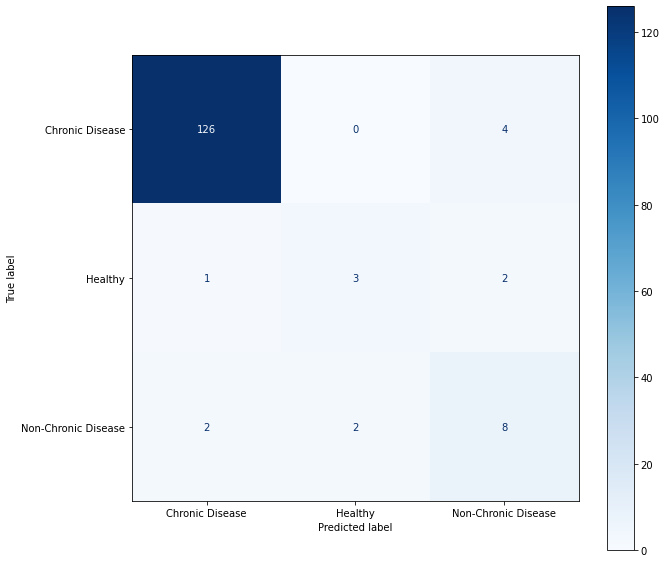

In [54]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### alexnet

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.6610169410705566.


Better model found at epoch 0 with accuracy value: 0.7118644118309021.
Better model found at epoch 1 with accuracy value: 0.7711864113807678.
Better model found at epoch 4 with accuracy value: 0.8305084705352783.
Better model found at epoch 11 with accuracy value: 0.8474576473236084.
Better model found at epoch 14 with accuracy value: 0.8644067645072937.
Better model found at epoch 15 with accuracy value: 0.8898305296897888.
Better model found at epoch 21 with accuracy value: 0.9067796468734741.
Better model found at epoch 25 with accuracy value: 0.9152542352676392.
No improvement since epoch 25: early stopping


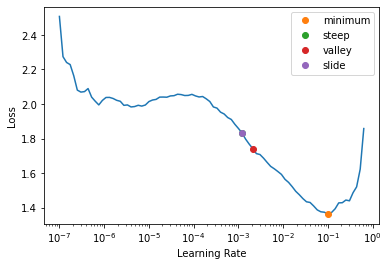

In [55]:
learn = cnn_learner(dls, alexnet, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

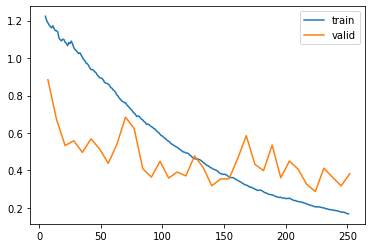

In [56]:
learn.recorder.plot_loss()

0.9054054054054054 0.9261025428589638 0.7498418722327642 0.8858974358974359 0.9663076498204916 0.6778309409888358
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       130
           1       0.45      0.83      0.59         6
           2       0.58      0.92      0.71        12

    accuracy                           0.91       148
   macro avg       0.68      0.89      0.75       148
weighted avg       0.94      0.91      0.92       148



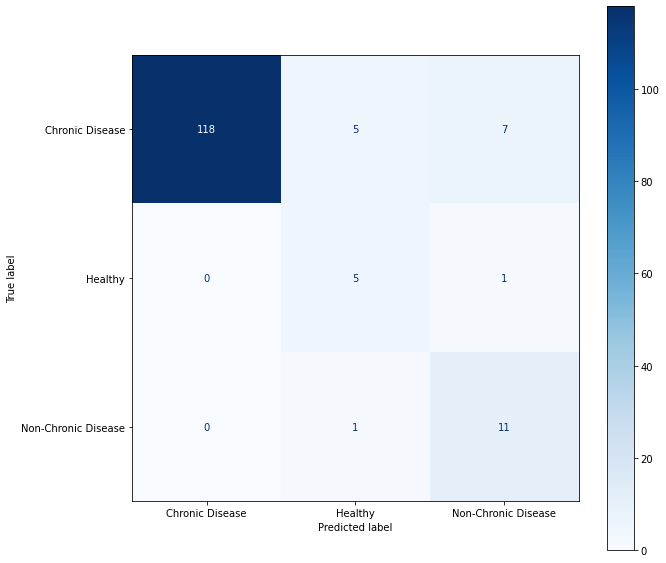

In [57]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### squeezenet1_0

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.7457627058029175.


Better model found at epoch 0 with accuracy value: 0.7372881174087524.
Better model found at epoch 1 with accuracy value: 0.7457627058029175.
Better model found at epoch 2 with accuracy value: 0.7796609997749329.
Better model found at epoch 6 with accuracy value: 0.805084764957428.
Better model found at epoch 8 with accuracy value: 0.8728813529014587.
No improvement since epoch 8: early stopping


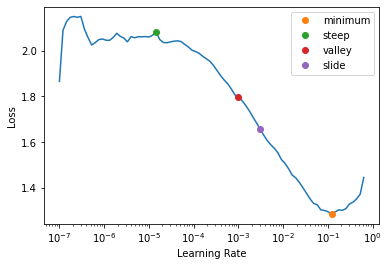

In [58]:
learn = cnn_learner(dls, squeezenet1_0, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

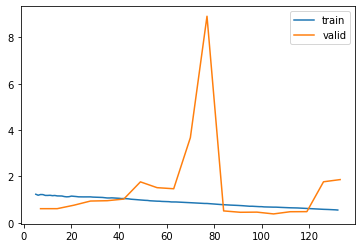

In [59]:
learn.recorder.plot_loss()

0.7837837837837838 0.7477469096462469 0.5054314408690305 0.6051282051282051 0.8903656141642885 0.4797205774217268
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.98      0.82      0.89       130
           1       0.18      0.33      0.24         6
           2       0.28      0.67      0.39        12

    accuracy                           0.78       148
   macro avg       0.48      0.61      0.51       148
weighted avg       0.89      0.78      0.82       148



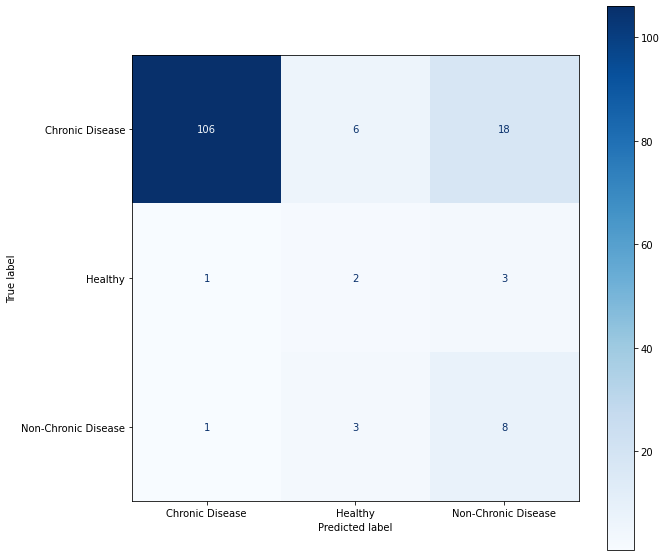

In [60]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### densenet121

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.3050847351551056.


Better model found at epoch 0 with accuracy value: 0.7203390002250671.
Better model found at epoch 1 with accuracy value: 0.7627118825912476.
Better model found at epoch 2 with accuracy value: 0.8474576473236084.
Better model found at epoch 3 with accuracy value: 0.8813559412956238.
Better model found at epoch 5 with accuracy value: 0.9067796468734741.
No improvement since epoch 5: early stopping


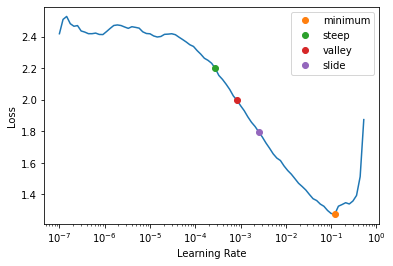

In [61]:
learn = cnn_learner(dls, densenet121, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

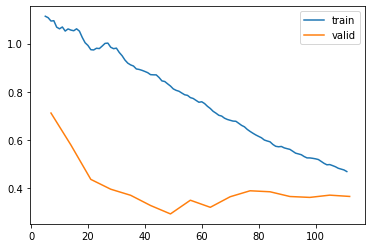

In [62]:
learn.recorder.plot_loss()

0.8243243243243243 0.7354516153397679 0.5266572995335947 0.5978632478632478 0.8730399828162877 0.4969961909144362
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       130
           1       0.23      0.50      0.32         6
           2       0.29      0.42      0.34        12

    accuracy                           0.82       148
   macro avg       0.50      0.60      0.53       148
weighted avg       0.88      0.82      0.85       148



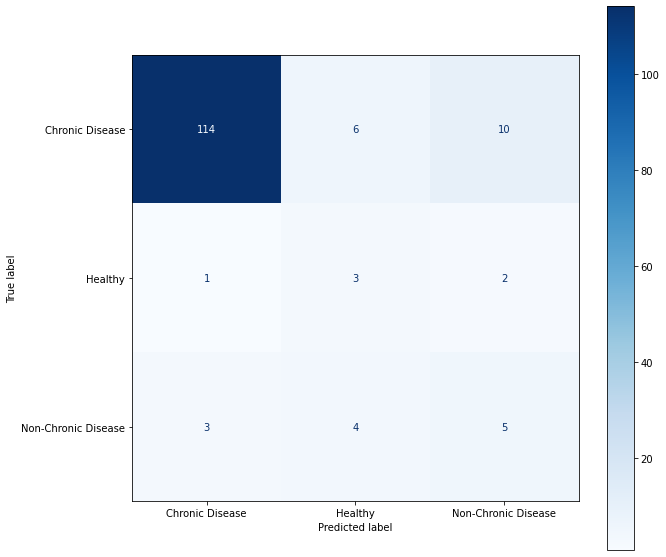

In [63]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### xresnet50

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth


  0%|          | 0.00/244M [00:00<?, ?B/s]

Better model found at epoch 0 with accuracy value: 0.8813559412956238.


Better model found at epoch 0 with accuracy value: 0.5.
Better model found at epoch 1 with accuracy value: 0.6610169410705566.
Better model found at epoch 2 with accuracy value: 0.7457627058029175.
Better model found at epoch 3 with accuracy value: 0.8220338821411133.
Better model found at epoch 4 with accuracy value: 0.8644067645072937.
Better model found at epoch 6 with accuracy value: 0.8813559412956238.
Better model found at epoch 10 with accuracy value: 0.9067796468734741.
Better model found at epoch 13 with accuracy value: 0.9237288236618042.
No improvement since epoch 13: early stopping


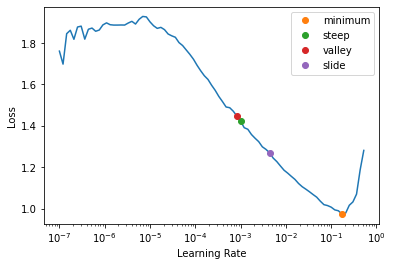

In [64]:
learn = cnn_learner(dls, xresnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fine_tune(50, lrs.valley)

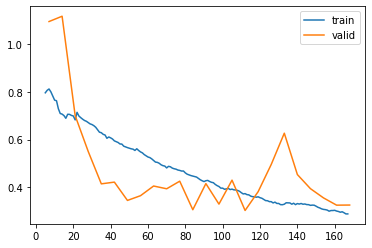

In [65]:
learn.recorder.plot_loss()

0.9054054054054054 0.8465118008200029 0.6547144754316069 0.7269230769230769 0.9661005247169291 0.6190476190476191
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       130
           1       0.33      0.33      0.33         6
           2       0.52      0.92      0.67        12

    accuracy                           0.91       148
   macro avg       0.62      0.73      0.65       148
weighted avg       0.93      0.91      0.91       148



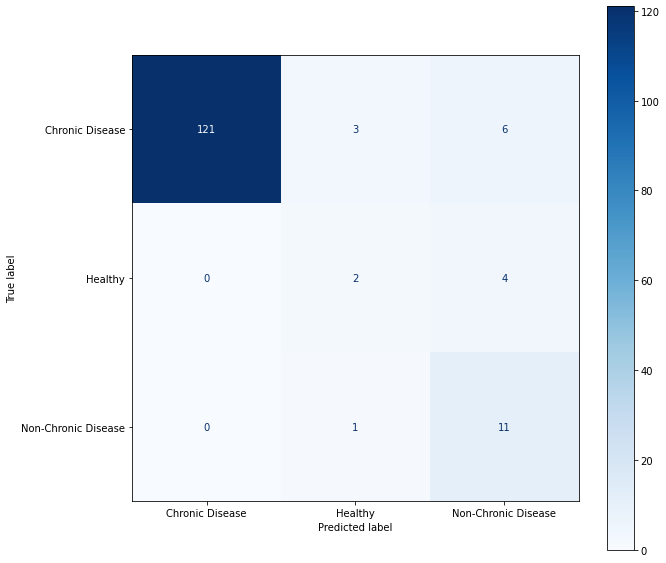

In [66]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

# Models: 1cycle policy

### ResNet-18

Better model found at epoch 0 with accuracy value: 0.19491524994373322.
Better model found at epoch 1 with accuracy value: 0.29661017656326294.
Better model found at epoch 2 with accuracy value: 0.6779661178588867.
Better model found at epoch 3 with accuracy value: 0.7372881174087524.
Better model found at epoch 4 with accuracy value: 0.7627118825912476.
Better model found at epoch 5 with accuracy value: 0.8474576473236084.
Better model found at epoch 6 with accuracy value: 0.8559321761131287.
Better model found at epoch 8 with accuracy value: 0.8644067645072937.
Better model found at epoch 9 with accuracy value: 0.8813559412956238.
Better model found at epoch 11 with accuracy value: 0.9152542352676392.
Better model found at epoch 12 with accuracy value: 0.9237288236618042.
No improvement since epoch 12: early stopping


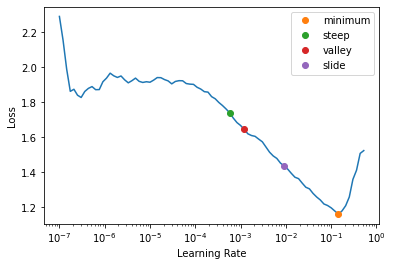

In [67]:
learn = cnn_learner(dls, resnet18, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

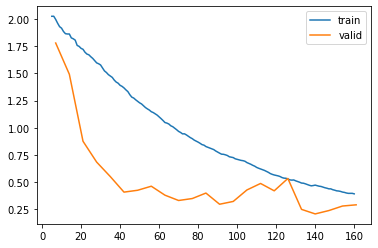

In [68]:
learn.recorder.plot_loss()

0.8851351351351351 0.9058695182659559 0.7270615563298491 0.8529914529914531 0.9587475835404584 0.6634460547504025
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       130
           1       0.56      0.83      0.67         6
           2       0.43      0.83      0.57        12

    accuracy                           0.89       148
   macro avg       0.66      0.85      0.73       148
weighted avg       0.94      0.89      0.90       148



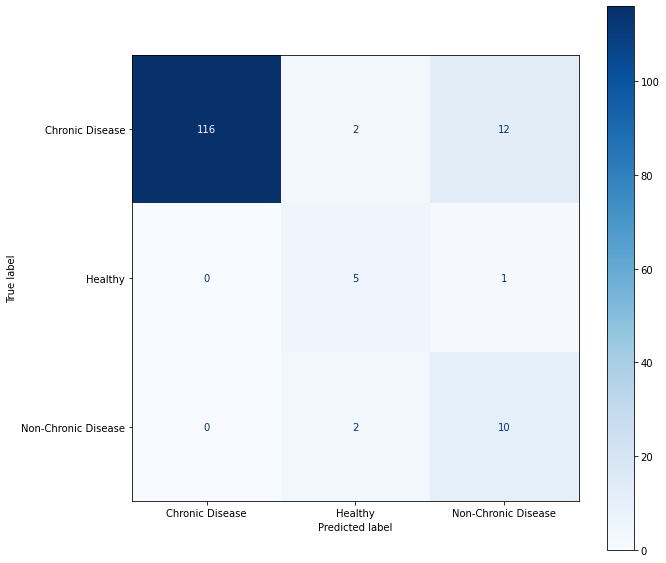

In [69]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### ResNet-34

Better model found at epoch 0 with accuracy value: 0.050847455859184265.
Better model found at epoch 1 with accuracy value: 0.5.
Better model found at epoch 2 with accuracy value: 0.7118644118309021.
Better model found at epoch 3 with accuracy value: 0.8220338821411133.
Better model found at epoch 4 with accuracy value: 0.8305084705352783.
Better model found at epoch 5 with accuracy value: 0.8389830589294434.
Better model found at epoch 7 with accuracy value: 0.8559321761131287.
Better model found at epoch 8 with accuracy value: 0.8898305296897888.
Better model found at epoch 10 with accuracy value: 0.9067796468734741.
Better model found at epoch 11 with accuracy value: 0.9152542352676392.
Better model found at epoch 12 with accuracy value: 0.9406779408454895.
Better model found at epoch 22 with accuracy value: 0.9576271176338196.
Better model found at epoch 24 with accuracy value: 0.9661017060279846.
No improvement since epoch 24: early stopping


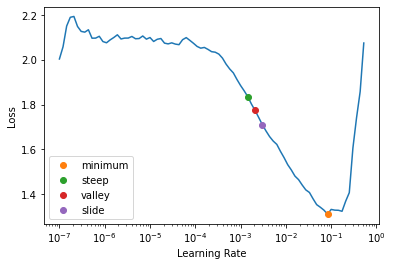

In [70]:
learn = cnn_learner(dls, resnet34, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

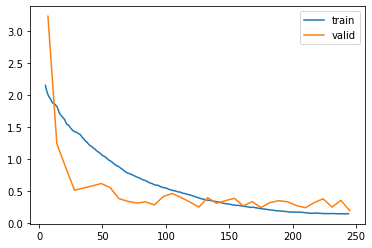

In [71]:
learn.recorder.plot_loss()

0.9054054054054054 0.8193266014724174 0.661437908496732 0.7042735042735043 0.9343796986713309 0.6411313131313131
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       130
           1       0.27      0.50      0.35         6
           2       0.67      0.67      0.67        12

    accuracy                           0.91       148
   macro avg       0.64      0.70      0.66       148
weighted avg       0.93      0.91      0.92       148



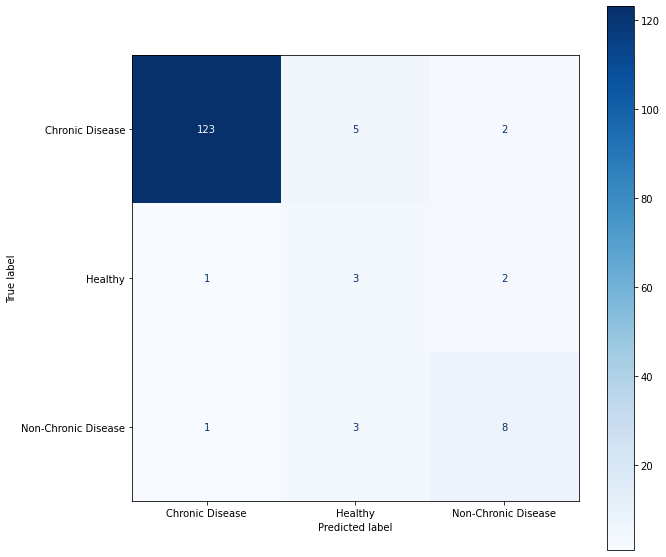

In [72]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### ResNet-50

Better model found at epoch 0 with accuracy value: 0.7796609997749329.
Better model found at epoch 3 with accuracy value: 0.8220338821411133.
Better model found at epoch 5 with accuracy value: 0.8559321761131287.
Better model found at epoch 7 with accuracy value: 0.9067796468734741.
Better model found at epoch 11 with accuracy value: 0.9237288236618042.
Better model found at epoch 21 with accuracy value: 0.9322034120559692.
Better model found at epoch 25 with accuracy value: 0.9406779408454895.
Better model found at epoch 30 with accuracy value: 0.9491525292396545.
Better model found at epoch 32 with accuracy value: 0.9576271176338196.
No improvement since epoch 32: early stopping


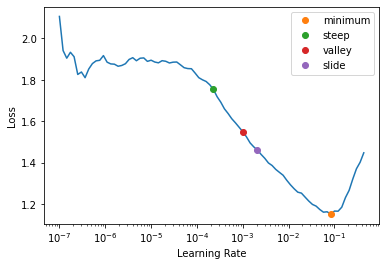

In [73]:
learn = cnn_learner(dls, resnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

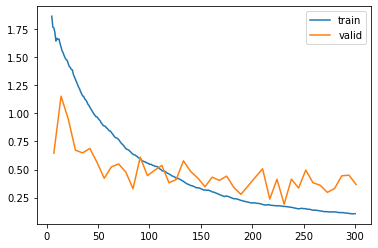

In [74]:
learn.recorder.plot_loss()

0.918918918918919 0.8101421078844443 0.6644841003622702 0.6816239316239315 0.938660284144957 0.6712212444032731
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       130
           1       0.50      0.33      0.40         6
           2       0.53      0.75      0.62        12

    accuracy                           0.92       148
   macro avg       0.67      0.68      0.66       148
weighted avg       0.93      0.92      0.92       148



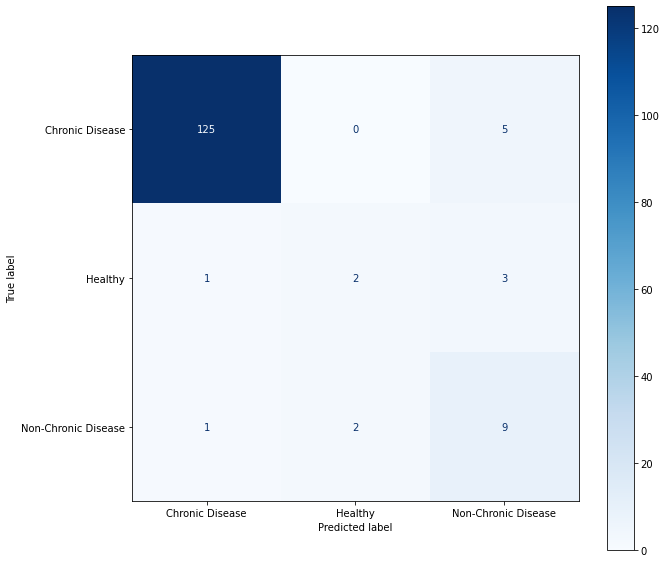

In [75]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### ResNet-101

Better model found at epoch 0 with accuracy value: 0.6610169410705566.
Better model found at epoch 3 with accuracy value: 0.7627118825912476.
Better model found at epoch 4 with accuracy value: 0.8305084705352783.
Better model found at epoch 7 with accuracy value: 0.8389830589294434.
Better model found at epoch 8 with accuracy value: 0.8644067645072937.
Better model found at epoch 9 with accuracy value: 0.9152542352676392.
No improvement since epoch 9: early stopping


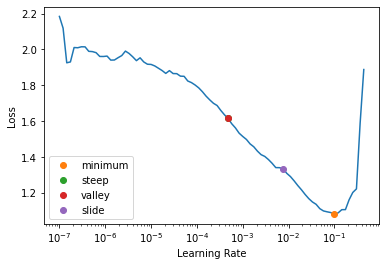

In [76]:
learn = cnn_learner(dls, resnet101, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

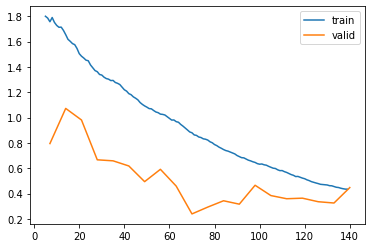

In [77]:
learn.recorder.plot_loss()

0.8783783783783784 0.8276030491647725 0.6689685701637892 0.747008547008547 0.9081975513209978 0.6213651668197123
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       130
           1       0.44      0.67      0.53         6
           2       0.44      0.67      0.53        12

    accuracy                           0.88       148
   macro avg       0.62      0.75      0.67       148
weighted avg       0.91      0.88      0.89       148



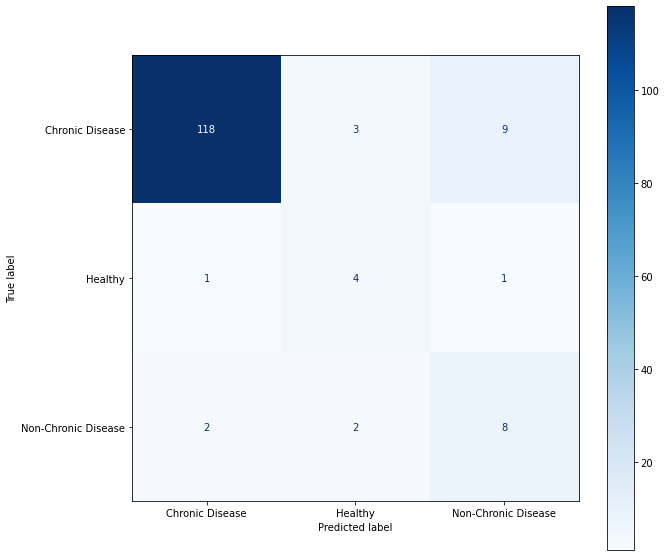

In [78]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### vgg16_bn

Better model found at epoch 0 with accuracy value: 0.10169491171836853.
Better model found at epoch 1 with accuracy value: 0.26271185278892517.
Better model found at epoch 2 with accuracy value: 0.6101694703102112.
Better model found at epoch 3 with accuracy value: 0.7711864113807678.
Better model found at epoch 4 with accuracy value: 0.805084764957428.
Better model found at epoch 5 with accuracy value: 0.8559321761131287.
Better model found at epoch 6 with accuracy value: 0.8644067645072937.
Better model found at epoch 10 with accuracy value: 0.9067796468734741.
Better model found at epoch 13 with accuracy value: 0.9152542352676392.
Better model found at epoch 23 with accuracy value: 0.9237288236618042.
Better model found at epoch 29 with accuracy value: 0.9322034120559692.
Better model found at epoch 30 with accuracy value: 0.9406779408454895.
Better model found at epoch 34 with accuracy value: 0.9491525292396545.
Better model found at epoch 39 with accuracy value: 0.9576271176338196

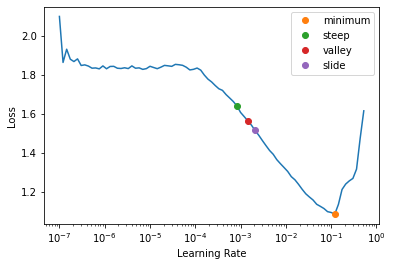

In [79]:
learn = cnn_learner(dls, vgg16_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

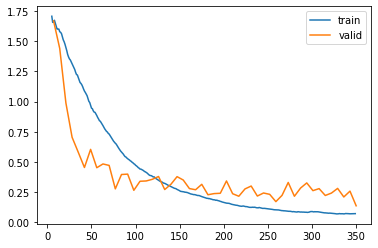

In [80]:
learn.recorder.plot_loss()

0.9121621621621622 0.867377737178897 0.7241462241462241 0.7824786324786325 0.9522768418791617 0.7052042674993495
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       130
           1       0.60      0.50      0.55         6
           2       0.52      0.92      0.67        12

    accuracy                           0.91       148
   macro avg       0.71      0.78      0.72       148
weighted avg       0.94      0.91      0.92       148



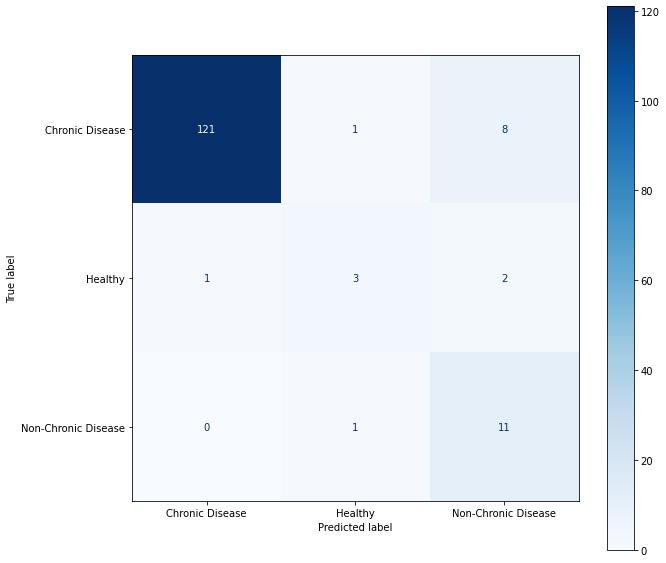

In [81]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### vgg19_bn

Better model found at epoch 0 with accuracy value: 0.26271185278892517.
Better model found at epoch 1 with accuracy value: 0.47457626461982727.
Better model found at epoch 2 with accuracy value: 0.6779661178588867.
Better model found at epoch 3 with accuracy value: 0.7457627058029175.
Better model found at epoch 4 with accuracy value: 0.7711864113807678.
Better model found at epoch 5 with accuracy value: 0.8135592937469482.
Better model found at epoch 6 with accuracy value: 0.8305084705352783.
Better model found at epoch 8 with accuracy value: 0.8813559412956238.
Better model found at epoch 10 with accuracy value: 0.8898305296897888.
Better model found at epoch 14 with accuracy value: 0.9067796468734741.
Better model found at epoch 16 with accuracy value: 0.9322034120559692.
Better model found at epoch 20 with accuracy value: 0.9661017060279846.
No improvement since epoch 20: early stopping


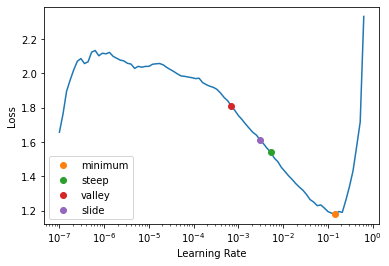

In [82]:
learn = cnn_learner(dls, vgg19_bn, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

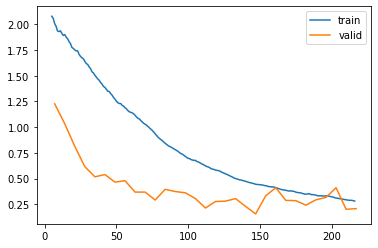

In [83]:
learn.recorder.plot_loss()

0.9054054054054054 0.8869999787563997 0.708888888888889 0.8076923076923078 0.9663076498204916 0.6518518518518518
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       130
           1       0.40      0.67      0.50         6
           2       0.56      0.83      0.67        12

    accuracy                           0.91       148
   macro avg       0.65      0.81      0.71       148
weighted avg       0.94      0.91      0.92       148



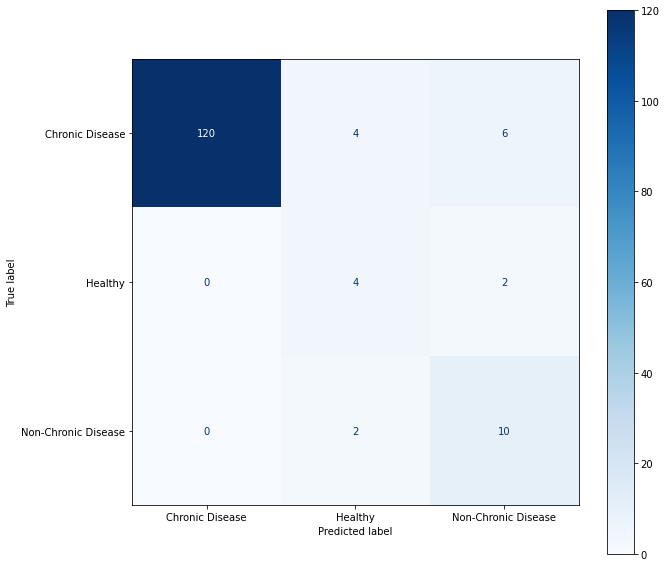

In [84]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### alexnet

Better model found at epoch 0 with accuracy value: 0.3644067943096161.
Better model found at epoch 1 with accuracy value: 0.5932203531265259.
Better model found at epoch 2 with accuracy value: 0.7542372941970825.
Better model found at epoch 3 with accuracy value: 0.7796609997749329.
Better model found at epoch 4 with accuracy value: 0.7881355881690979.
Better model found at epoch 5 with accuracy value: 0.8135592937469482.
Better model found at epoch 6 with accuracy value: 0.8389830589294434.
Better model found at epoch 11 with accuracy value: 0.8474576473236084.
Better model found at epoch 12 with accuracy value: 0.8559321761131287.
Better model found at epoch 18 with accuracy value: 0.8898305296897888.
No improvement since epoch 18: early stopping


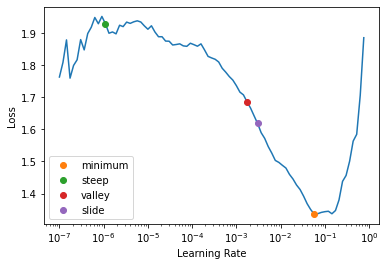

In [85]:
learn = cnn_learner(dls, alexnet, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

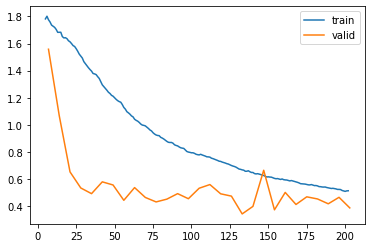

In [86]:
learn.recorder.plot_loss()

0.8243243243243243 0.8305173170748978 0.5883583558946591 0.723931623931624 0.9371030102181718 0.5432900432900433
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       1.00      0.84      0.91       130
           1       0.27      0.50      0.35         6
           2       0.36      0.83      0.50        12

    accuracy                           0.82       148
   macro avg       0.54      0.72      0.59       148
weighted avg       0.92      0.82      0.86       148



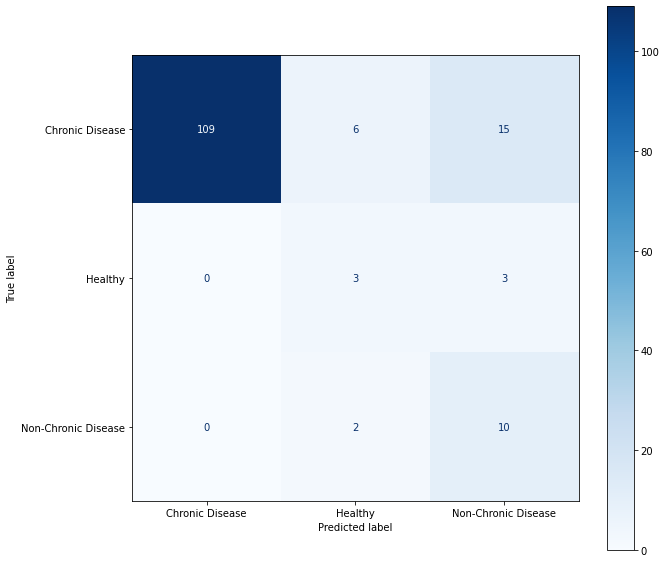

In [87]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### squeezenet1_0

Better model found at epoch 0 with accuracy value: 0.37288135290145874.
Better model found at epoch 1 with accuracy value: 0.38983049988746643.
Better model found at epoch 2 with accuracy value: 0.5508474707603455.
Better model found at epoch 3 with accuracy value: 0.6440678238868713.
Better model found at epoch 4 with accuracy value: 0.6610169410705566.
Better model found at epoch 5 with accuracy value: 0.7033898234367371.
Better model found at epoch 6 with accuracy value: 0.7542372941970825.
Better model found at epoch 7 with accuracy value: 0.7796609997749329.
Better model found at epoch 8 with accuracy value: 0.805084764957428.
Better model found at epoch 12 with accuracy value: 0.8559321761131287.
No improvement since epoch 12: early stopping


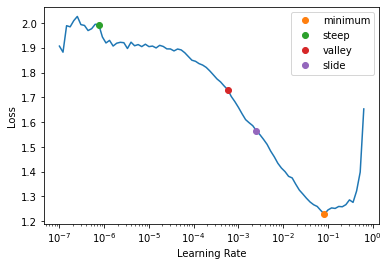

In [88]:
learn = cnn_learner(dls, squeezenet1_0, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

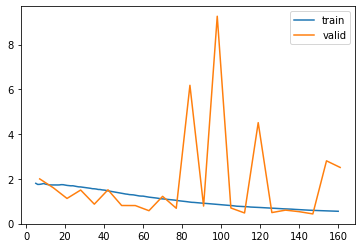

In [89]:
learn.recorder.plot_loss()

0.7297297297297297 0.7245509043872755 0.4595959595959596 0.561965811965812 0.887135996808739 0.44878300330033
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.99      0.77      0.87       130
           1       0.20      0.50      0.29         6
           2       0.16      0.42      0.23        12

    accuracy                           0.73       148
   macro avg       0.45      0.56      0.46       148
weighted avg       0.89      0.73      0.79       148



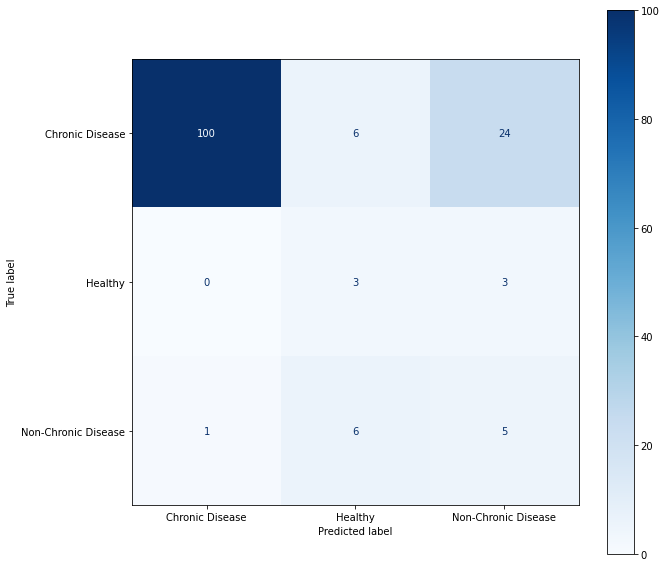

In [90]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### densenet121

Better model found at epoch 0 with accuracy value: 0.11016949266195297.
Better model found at epoch 1 with accuracy value: 0.31355932354927063.
Better model found at epoch 2 with accuracy value: 0.6016949415206909.
Better model found at epoch 3 with accuracy value: 0.8135592937469482.
Better model found at epoch 5 with accuracy value: 0.8389830589294434.
Better model found at epoch 6 with accuracy value: 0.8644067645072937.
Better model found at epoch 9 with accuracy value: 0.8813559412956238.
Better model found at epoch 10 with accuracy value: 0.9067796468734741.
Better model found at epoch 17 with accuracy value: 0.9152542352676392.
Better model found at epoch 19 with accuracy value: 0.9406779408454895.
Better model found at epoch 29 with accuracy value: 0.9491525292396545.
Better model found at epoch 34 with accuracy value: 0.9576271176338196.
No improvement since epoch 34: early stopping


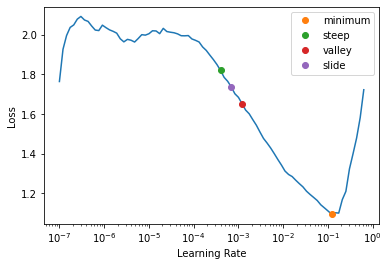

In [91]:
learn = cnn_learner(dls, densenet121, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

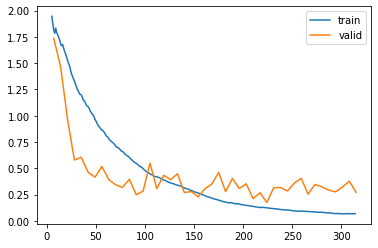

In [92]:
learn.recorder.plot_loss()

0.8918918918918919 0.8002155045237066 0.6235000779180303 0.6713675213675213 0.9290634876798919 0.5969191270860077
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       130
           1       0.33      0.33      0.33         6
           2       0.47      0.75      0.58        12

    accuracy                           0.89       148
   macro avg       0.60      0.67      0.62       148
weighted avg       0.92      0.89      0.90       148



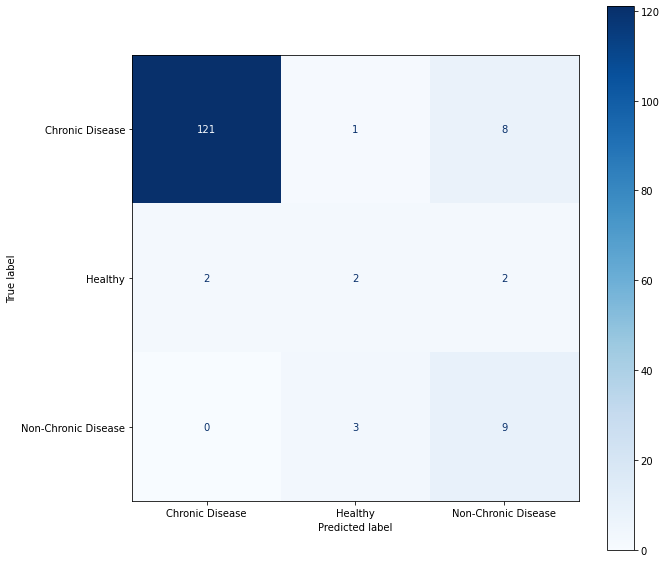

In [93]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()

### xresnet50

Better model found at epoch 0 with accuracy value: 0.8813559412956238.
Better model found at epoch 9 with accuracy value: 0.8898305296897888.
Better model found at epoch 14 with accuracy value: 0.8983050584793091.
Better model found at epoch 17 with accuracy value: 0.9406779408454895.
No improvement since epoch 17: early stopping


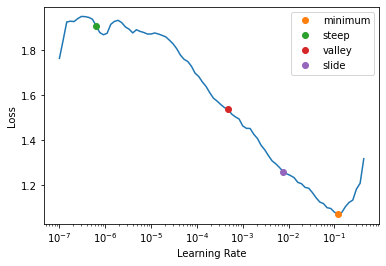

In [94]:
learn = cnn_learner(dls, xresnet50, # <- model
                    n_in=1,  # <- This is the only audio specific modification here                    
                    metrics=[accuracy, RocAuc(average='macro')],
                    cbs=(SaveModelCallback(monitor='accuracy', with_opt=True),
                         EarlyStoppingCallback(monitor='accuracy', patience=10))
                   )

# Find Learning Rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
#print(lrs.valley, lrs.slide, lrs.steep, lrs.minimum)

# Run 
learn.fit_one_cycle(50, lrs.valley)

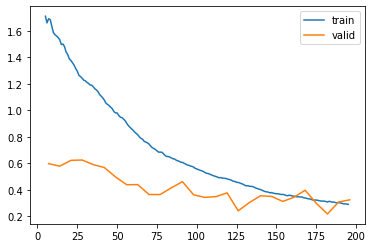

In [95]:
learn.recorder.plot_loss()

0.9256756756756757 0.9208629858588434 0.7830687830687831 0.8683760683760684 0.9733499033416183 0.7268518518518517
^^  accuracy, rocauc, f1, recall, specificity, precision    ^^
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       130
           1       0.62      0.83      0.71         6
           2       0.56      0.83      0.67        12

    accuracy                           0.93       148
   macro avg       0.73      0.87      0.78       148
weighted avg       0.95      0.93      0.93       148



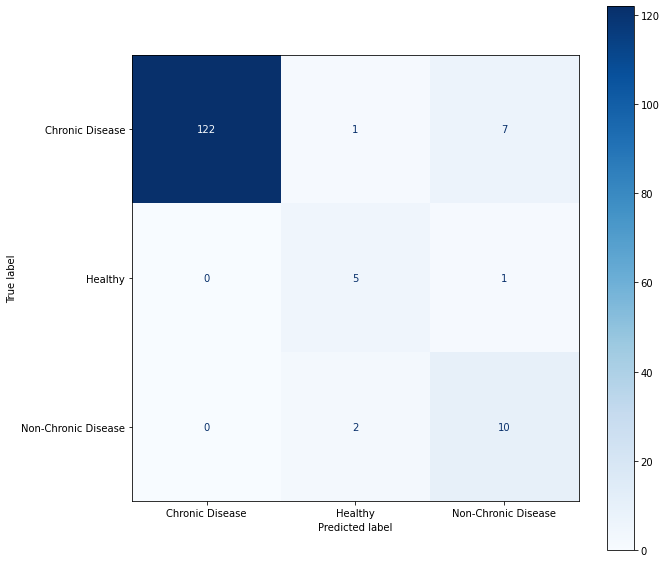

In [96]:
xx = learn.load('./model')
pred_probas, actual_classes, pred_classes = xx.get_preds(dl=test_dl, with_decoded=True)
actual_classesX = to_categorical(actual_classes, num_classes=3)
pred_classesX = to_categorical(pred_classes, num_classes=3)

rocauc = roc_auc_score(actual_classesX, pred_classesX, average='macro', multi_class='ovo')
acc = accuracy_score(actual_classes, pred_classes)
fone= f1_score(actual_classes, pred_classes, average='macro')
rec = recall_score(actual_classes, pred_classes, average='macro')
prec = precision_score(actual_classes, pred_classes, average='macro')
spc = specificity_score(actual_classes, pred_classes, average='macro')


print(acc, rocauc, fone, rec, spc, prec)
print('^^  accuracy, rocauc, f1, recall, specificity, precision    ^^')

print(classification_report(actual_classes, pred_classes))   

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(actual_classes, pred_classes, 
                                        display_labels=test_dl.vocab, cmap=plt.cm.Blues, ax=ax)

plt.show()